# Clustering algorithms for charactarization of random neural networks
## Willis Hoke

## Part 1: Generating random networks

A network contains a random weight matrix and a vector of outputs. Weights are initialized using a standard normal distribution. The `tanh` (hyperbolic tangent) activation function constrains output to range [-1,1]. The `process` method runs the network for a single time step by feeding outputs back to inputs.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class Network:
    def __init__(self, size):
        self.weights = np.random.randn(size, size)
        self.outputs = np.zeros(size)
        self.outputs[0] = 1.
    
    # apply nonlinear transformation
    def process(self):
        self.outputs = np.tanh(self.weights @ self.outputs)
        return self.outputs

### Example: 3-dimensional systems

Below we generate random random networks with 3 neurons each and plot the output in 3 dimensions.

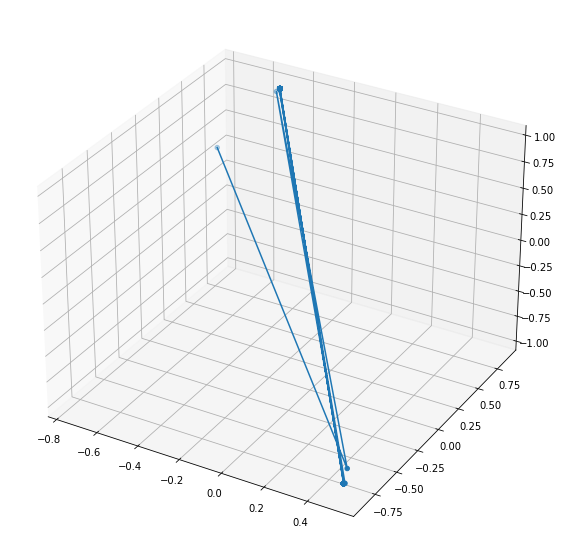

In [3]:
n = Network(3)
t = 10000

# keep record of network output over time
history = []
for j in range(t):
    history.append(n.process())
        
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*np.array(history).T)
ax.scatter(*np.array(history).T)

plt.show()

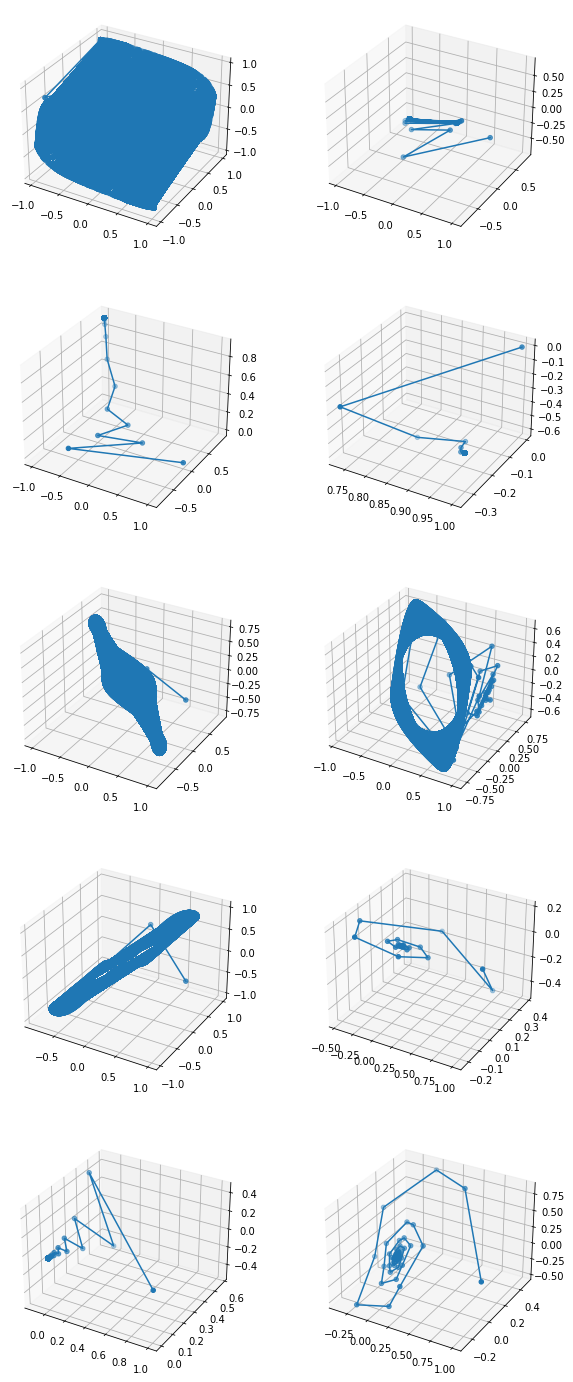

In [4]:
fig = plt.figure(figsize=(10,25))

for i in range(10):
    n1 = Network(3)
    t = 10000

    history = [n1.outputs]
    for j in range(t):
        history.append(n1.process())

    ax = fig.add_subplot(5,2,i+1, projection='3d')
    x, y, z = np.array(history).T
    ax.scatter(x, y, z)
    ax.plot3D(x, y, z)

plt.show()

### Network dynamics

As can be seen above, even simple networks are capable of highly complex behavior, with some even displaying chaotic behavior. However, most networks seem to converge on a particular set of values, with periodic oscillations apparent. Some even converge to a single fixed point. This becomes clearer if we truncate the first few time steps. 

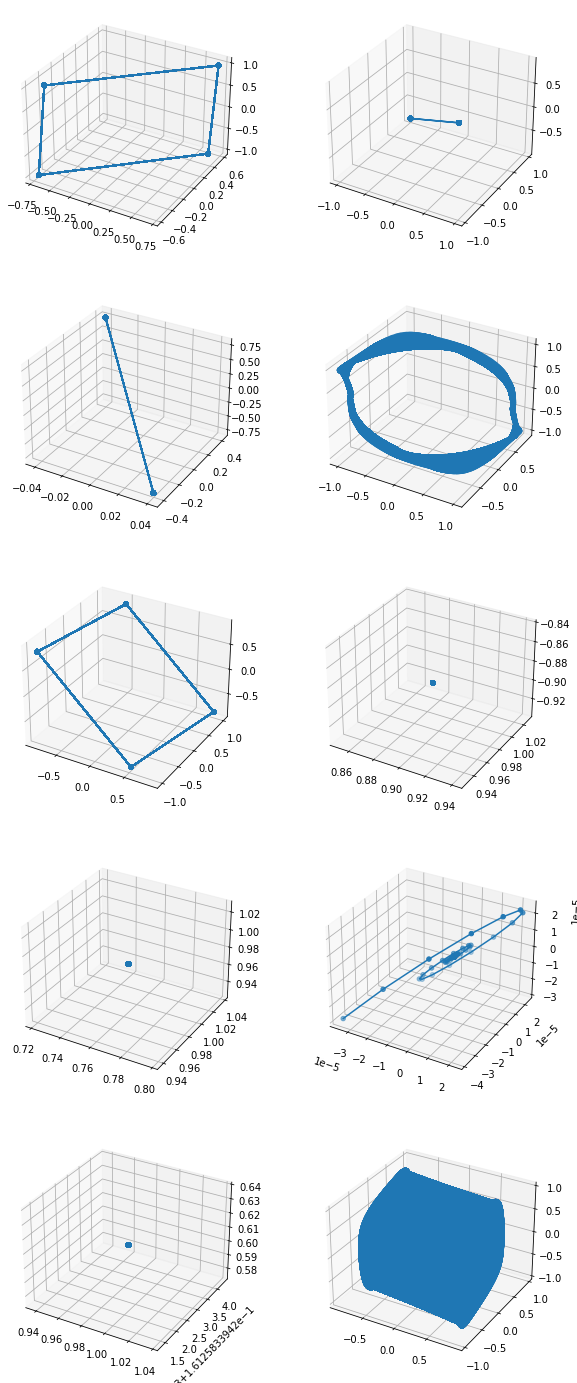

In [3]:
fig = plt.figure(figsize=(10,25))

for i in range(10):
    n1 = Network(3)
    t = 10000

    history = [n1.outputs]
    for j in range(t):
        history.append(n1.process())

    ax = fig.add_subplot(5,2,i+1, projection='3d')
    x, y, z = np.array(history)[100:].T
    ax.scatter(x, y, z)
    ax.plot3D(x, y, z)

plt.show()

### Visualizing large networks with dimensionality reduction

Since our output is a vector $x \in \mathbb{R}^d$, for values of $d$ larger than 3 it becomes impossible to display the exact output for all dimensions on a 3D plot. Thus, it is necessary to use a dimensionality reduction technique to provide an approximation of the network output in a lower dimensional space. Using PCA ensures that the most important aspects of a network's behavior are represented in the 3D visualization. Moving forward, this technique will be used to measure the results of applying adaptive clustering algorithms on high-dimensional data. Surprisingly, even with 10 neurons, network behavior is often similar to smaller networks. However, chaotic behavior tends to be more prevalent with increasing numbers of neurons.

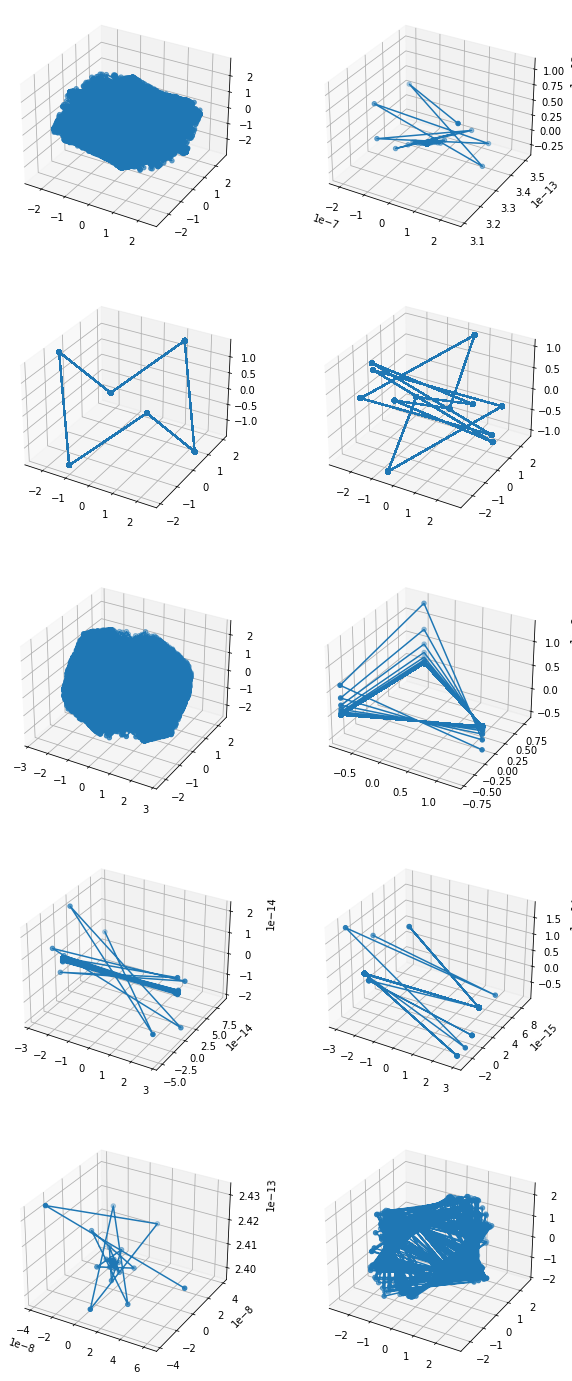

In [5]:
from sklearn.decomposition import PCA

fig = plt.figure(figsize=(10,25))

for i in range(10):
    n = Network(10)
    t = 10000

    history = []
    for j in range(t):
        result = n.process()
        if j > 100:
            history.append(result)

    pca = PCA(n_components=3)
    dim_reduce = pca.fit_transform(history)

    ax = fig.add_subplot(5,2,i+1, projection='3d')
    x, y, z = np.array(dim_reduce).T
    ax.scatter(x, y, z)
    ax.plot3D(x, y, z)

plt.show()

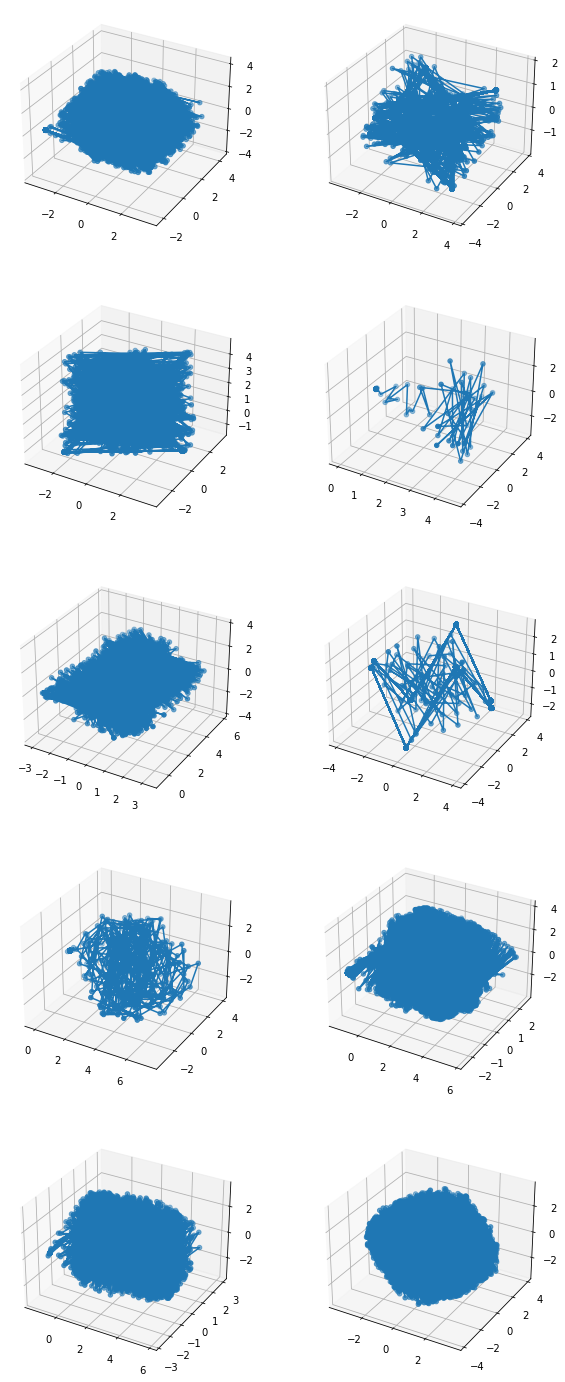

In [56]:
from sklearn.decomposition import PCA

fig = plt.figure(figsize=(10,25))

for i in range(10):
    n = Network(20)
    t = 10000

    history = []
    for j in range(t):
        if j > 100:
            history.append(n.process())

    pca = PCA(n_components=3)
    dim_reduce = pca.fit_transform(history)

    ax = fig.add_subplot(5,2,i+1, projection='3d')
    x, y, z = np.array(dim_reduce).T
    ax.scatter(x, y, z)
    ax.plot3D(x, y, z)

plt.show()

## Part 2: Adaptive Clustering

Here we use K-means to perform adaptive clustering. $k$ is a hyperparameter, so we iterate through successive values of $k$ to find the optimal result.

<ipython-input-24-e601e14ba8e3>:22: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  means.append(KM.fit(history))
<ipython-input-24-e601e14ba8e3>:22: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  means.append(KM.fit(history))
<ipython-input-24-e601e14ba8e3>:22: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  means.append(KM.fit(history))
<ipython-input-24-e601e14ba8e3>:22: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  means.append(KM.fit(history))
<ipython-input-24-e601e14ba8e3>:22: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  means.append(KM.fit(history))
<ipython-input-24-e601e14ba8e3

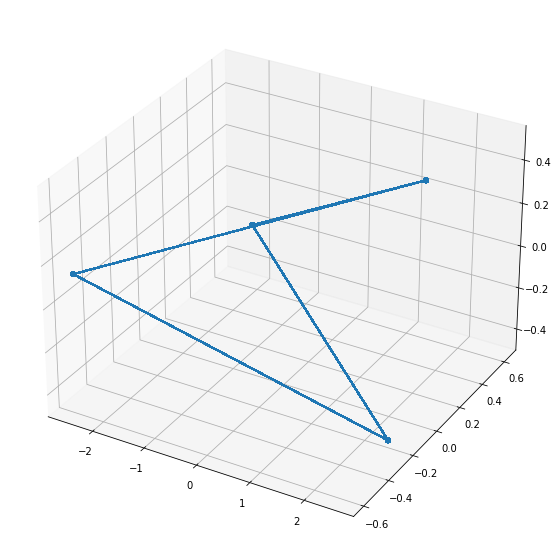

In [24]:
from sklearn.cluster import KMeans

n = Network(10)
t = 10000

history = []
for j in range(t):
    history.append(n.process())

history = history[1000:]
pca = PCA(n_components=3)
dim_reduce = pca.fit_transform(history)
        
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*np.array(dim_reduce).T)
ax.scatter(*np.array(dim_reduce).T)

means = []
for i in range(20):
    KM = KMeans(n_clusters=i+2)
    means.append(KM.fit(history))

### Elbow detection: Finding optimal $k$

We calculate Mean Squared Error (MSE) using Euclidean distance of each point from the centroid corresponding to its cluster assignment. By finding the second gradient of the error surface, we can identify the "elbow" of the loss graph. This gives us critical information about the behavior of the clustering algorithm. We want to use the minimum number of clusters sufficient to capture the behavior of the system.

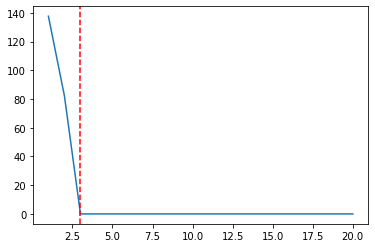

In [25]:
errors = []
for m in means:
    labels = m.labels_
    centers = m.cluster_centers_
    indexed = centers[labels]
    errors.append(np.sum(np.linalg.norm(history - indexed, axis=0), axis=0))
    
plt.plot(range(1,21), errors)

best_fit = np.argmax(np.gradient(np.gradient(errors))) + 1

plt.axvline(best_fit, linestyle='dashed', c='red')

plt.show()

### Visualizing clusterings

By applying clustering in high-dimensional space, then projecting down to lower dimensions, we can plot the cluster assignments to reveal the patterns identifed by the adaptive clustering algorithm.

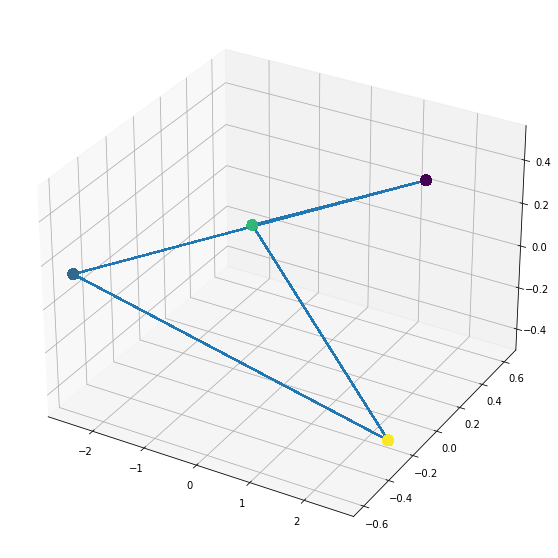

In [26]:
best_means = means[best_fit-1]
labels = best_means.labels_

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*dim_reduce.T)
ax.scatter(*dim_reduce.T, c=labels, s=100)
plt.show()

### Applying clustering to arbitrary networks

Using the elbow method with K-means, we identify candidate networks with periodic behavior. The script below combines together code from the previous sections. Networks with chaotic or aperiodic behavior are discarded, since clustering doesn't produce useful results for these. 

/usr/local/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:561: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ / total_var.sum()
<ipython-input-27-6176f2545e1a>:23: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  means.append(KM.fit(history))
<ipython-input-27-6176f2545e1a>:23: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  means.append(KM.fit(history))
<ipython-input-27-6176f2545e1a>:23: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  means.append(KM.fit(history))
<ipython-input-27-6176f2545e1a>:23: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  means.append(KM.fit(history))
<ipython-input-27-6176f2545e1a>:23: Convergence

<ipython-input-27-6176f2545e1a>:23: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  means.append(KM.fit(history))
<ipython-input-27-6176f2545e1a>:23: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  means.append(KM.fit(history))
<ipython-input-27-6176f2545e1a>:23: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  means.append(KM.fit(history))
<ipython-input-27-6176f2545e1a>:23: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  means.append(KM.fit(history))
<ipython-input-27-6176f2545e1a>:23: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  means.append(KM.fit(history))
<ipython-input-27-6176f2545e1

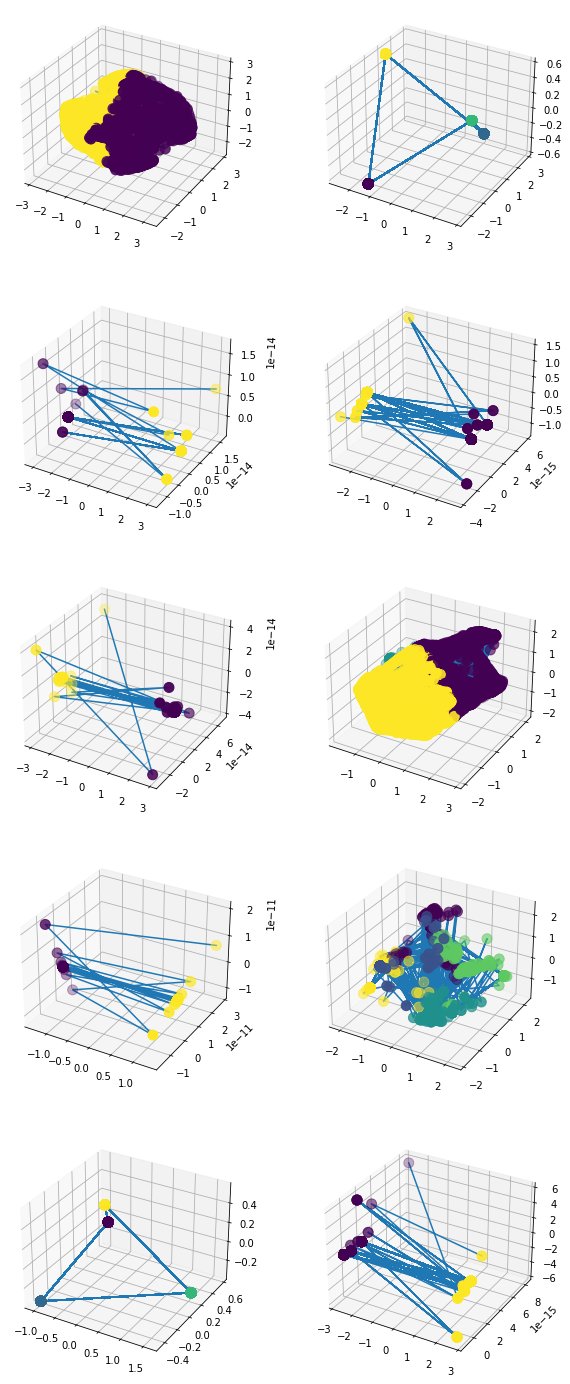

In [27]:
fig = plt.figure(figsize=(10,25))

# generate 10 solutions with visualizations
for i in range(10):
    
    # while loop exits when candidate network is found
    while(1):
        n = Network(10)
        t = 10000

        history = []
        for j in range(t):
            history.append(n.process())

        history = history[100:]
        
        pca = PCA(n_components=3)
        dim_reduce = pca.fit_transform(history)

        means = []
        for k in range(10):
            KM = KMeans(n_clusters=k+1)
            means.append(KM.fit(history))
        errors = []

        for m in means:
            labels = m.labels_
            centers = m.cluster_centers_
            indexed = centers[labels]
            errors.append(np.sum(np.linalg.norm(history - indexed, axis=0), axis=0))

        second_gradient = np.gradient(np.gradient(errors))
        best_fit = np.argmax(second_gradient) + 1
        if best_fit > 1 and best_fit < 10:
            break
    
    best_means = means[best_fit-1]
    labels = best_means.labels_

    ax = fig.add_subplot(5,2,i+1, projection='3d')    
    ax.plot(*dim_reduce.T)
    ax.scatter(*dim_reduce.T, c=labels, s=100)

plt.show()

## Analysis

Using dimensionality reduction techniques such as PCA lets us visualize high-dimensional data from random neural networks. By using the elbow method with variable $k$ for K-means clustering, we can identify the oscillation frequency of systems with periodic behavior. The period corresponds to the number of clusters whose second gradient is highest. In cases where periodic behavior exists, the elbow method works quite well for identifying clusters. In cases where there is a smooth manifold (aperiodic or chaotic behavior), the clustering algorithm frequently produces spurious results. It may be possible to use gradient values to identify suboptimal clusterings, especially in cases where network behavior is chaotic.